In [1]:
import celltypist
from celltypist import models
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import scipy.sparse as scs
import concurrent.futures
import scanpy.external as sce
import gc
from concurrent.futures import ProcessPoolExecutor
import copy


In [2]:


def run_leiden(adata, resolution, key_added):
    # Make a copy of adata for thread safety
    adata_copy = copy.deepcopy(adata)
    adata_clustering = sc.tl.leiden(adata_copy, resolution=resolution, key_added=key_added, copy=True)
    return adata_clustering.obs

def run_leiden_parallel(adata, tasks):
    with ProcessPoolExecutor(max_workers=5) as executor:
        # Make deep copies of adata for each task to ensure thread safety
        futures = [executor.submit(run_leiden, copy.deepcopy(adata), resolution, key_added) for resolution, key_added in tasks]
        
        results = [future.result() for future in futures]

    # Assign the results back to the original AnnData object
    for result, (_, key_added) in zip(results, tasks):
        adata.obs[key_added] = result[key_added]

    return adata

In [3]:
adata=sc.read_h5ad('adata_processed.h5ad')

In [3]:
T_cell_population=["1","2","3","4","6","7","9","10","13","22","25","26","30"]

In [5]:
adata_subset=adata[adata.obs['leiden'].isin(T_cell_population)]

In [6]:
del adata 
gc.collect()

12

In [7]:
adata_subset=adata_subset.raw.to_adata()

In [8]:
adata_subset.write_h5ad('T/Tcells_raw.h5ad')

In [9]:
adata_subset=sc.read_h5ad('T/Tcells_raw.h5ad')

In [10]:
adata_subset.raw= adata_subset

In [11]:
sc.pp.normalize_total(adata_subset, target_sum=1e4)

In [12]:
sc.pp.log1p(adata_subset)
sc.pp.highly_variable_genes(adata_subset)
adata_subset = adata_subset[:, adata_subset.var_names[adata_subset.var['highly_variable']]]

In [13]:
sc.pp.scale(adata_subset)

In [14]:
sc.tl.pca(adata_subset, svd_solver='arpack')

In [15]:
sce.pp.harmony_integrate(adata_subset, 'cohort.cohortGuid',max_iter_harmony = 30)

2023-11-21 03:29:15,873 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2023-11-21 03:45:45,271 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2023-11-21 03:45:53,316 - harmonypy - INFO - Iteration 1 of 30
Iteration 1 of 30
2023-11-21 04:00:04,800 - harmonypy - INFO - Iteration 2 of 30
Iteration 2 of 30
2023-11-21 04:11:54,968 - harmonypy - INFO - Iteration 3 of 30
Iteration 3 of 30
2023-11-21 04:21:53,446 - harmonypy - INFO - Converged after 3 iterations
Converged after 3 iterations


In [16]:
sc.pp.neighbors(adata_subset, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)

In [17]:
sc.tl.umap(adata_subset,min_dist=0.05)

In [18]:
adata_subset.write_h5ad('T/Tcells_processed_before_leiden.h5ad')

In [4]:
adata_subset=sc.read_h5ad('T/Tcells_processed_before_leiden.h5ad')

In [5]:
%%time

tasks = [(1, "leiden_resolution_1"),(1.5, "leiden_resolution_1.5"),(2, "leiden_resolution_2")]
adata_subset = run_leiden_parallel(adata_subset, tasks)

CPU times: user 1min 5s, sys: 2min 33s, total: 3min 38s
Wall time: 16h 50min 37s


In [6]:
adata_subset.write_h5ad('T/Tcells_processed_test.h5ad')

In [ ]:
adata_subset=adata_subset.raw.to_adata()
sc.pp.normalize_total(adata_subset, target_sum=1e4)
sc.pp.log1p(adata_subset)

sc.tl.rank_genes_groups(adata_subset, 'leiden_resolution_1', method='wilcoxon')
df_resolution_1=sc.get.rank_genes_groups_df(adata_subset,group=None)
df_resolution_1.to_csv('T/T_res1.csv')

sc.tl.rank_genes_groups(adata_subset, 'leiden_resolution_1.5', method='wilcoxon')
df_resolution_1_5=sc.get.rank_genes_groups_df(adata_subset,group=None)
df_resolution_1_5.to_csv('T/T_res1.5.csv')

sc.tl.rank_genes_groups(adata_subset, 'leiden_resolution_2', method='wilcoxon')
df_resolution_2=sc.get.rank_genes_groups_df(adata_subset,group=None)
df_resolution_2.to_csv('T/T_res2.csv')


In [17]:
adata_subset.raw=adata_subset

In [ ]:
adata_subset.write_h5ad('T/Tcells_processed.h5ad')

In [ ]:
adata_subset=sc.read_h5ad('T/Tcells_processed.h5ad')

In [ ]:
adata_subset.obs['selection'] =pd.Categorical( adata_subset.obs['predicted.celltype.l3']=='CD8 TEM_6')
# adjust colors
adata_subset.uns['selection_colors'] = ['blue', 'yellow']
sc.pl.umap(adata_subset, color='selection', add_outline=True, s=20)

<Axes: title={'center': 'predicted.celltype.l2.5'}, xlabel='UMAP1', ylabel='UMAP2'>

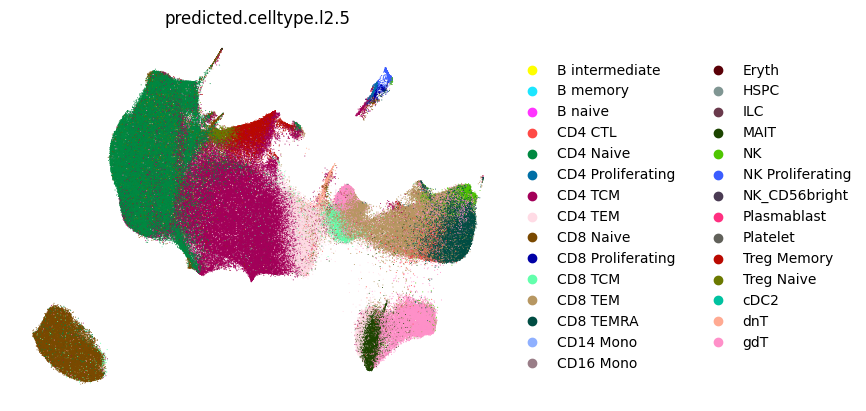

In [30]:
sc.pl.umap(adata_subset_raw, color=['predicted.celltype.l2.5'], size=2,show=False,ncols=1 ,frameon=False)

<Axes: title={'center': 'predicted_labels_celltypist'}, xlabel='UMAP1', ylabel='UMAP2'>

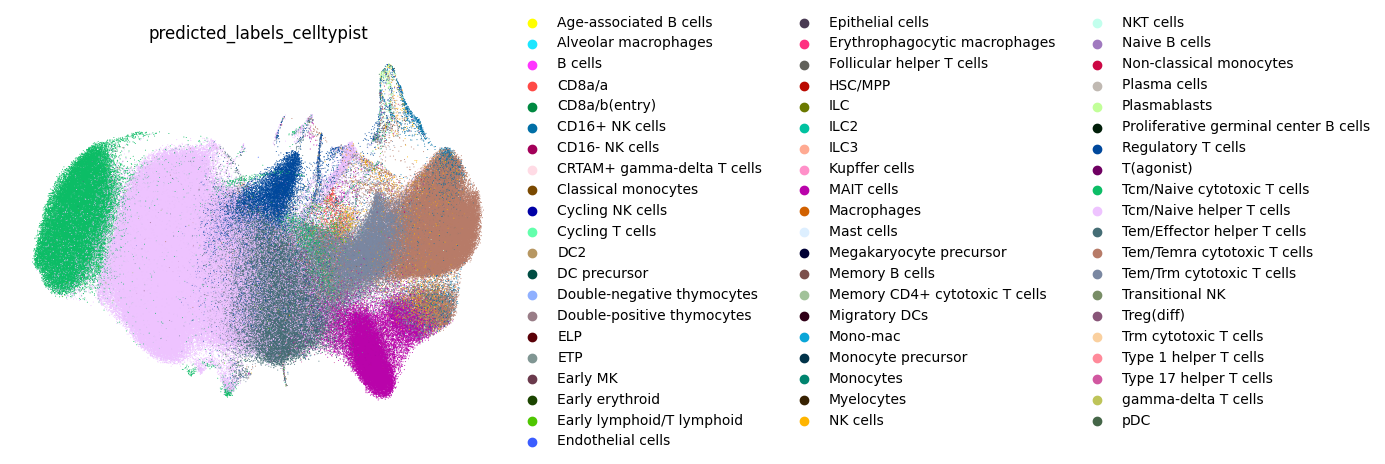

In [16]:
sc.pl.umap(adata_subset, color=['predicted_labels_celltypist'], size=2,show=False,ncols=1 ,frameon=False)

<Axes: title={'center': 'majority_voting_celltypist'}, xlabel='UMAP1', ylabel='UMAP2'>

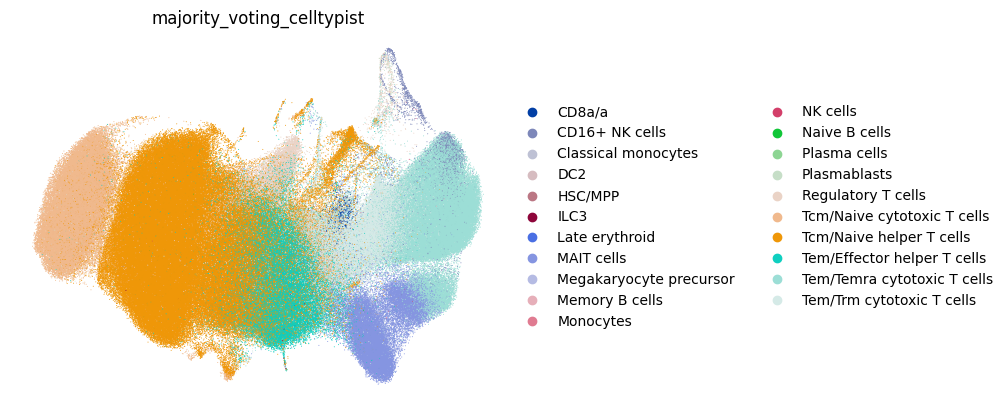

In [17]:
sc.pl.umap(adata_subset, color=['majority_voting_celltypist'], size=2,show=False,ncols=1 ,frameon=False)

In [ ]:
sc.pl.umap(adata_subset, color=['leiden_resolution_1','leiden_resolution_1.5','leiden_resolution_2'], 
           size=2,show=False,ncols=1 ,frameon=False)

In [ ]:
sc.pl.umap(adata_subset, color=['CD8A','CD8B','CD4'], 
           size=0.5,show=False,ncols=1 ,frameon=False)

<Axes: title={'center': 'CMV.IgG.Serology.Result.Interpretation'}, xlabel='UMAP1', ylabel='UMAP2'>

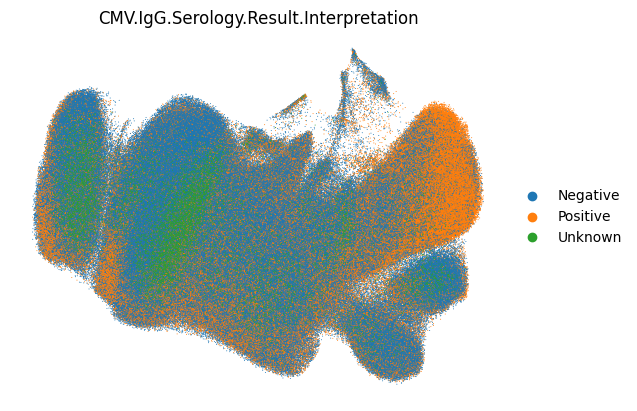

In [33]:
sc.pl.umap(adata_subset, color=['CMV.IgG.Serology.Result.Interpretation'], size=2,show=False,ncols=1 ,frameon=False)

In [40]:
df=pd.read_csv('T/T_res2.csv')

In [41]:
df=df.groupby('group').head(20).reset_index(drop=True)

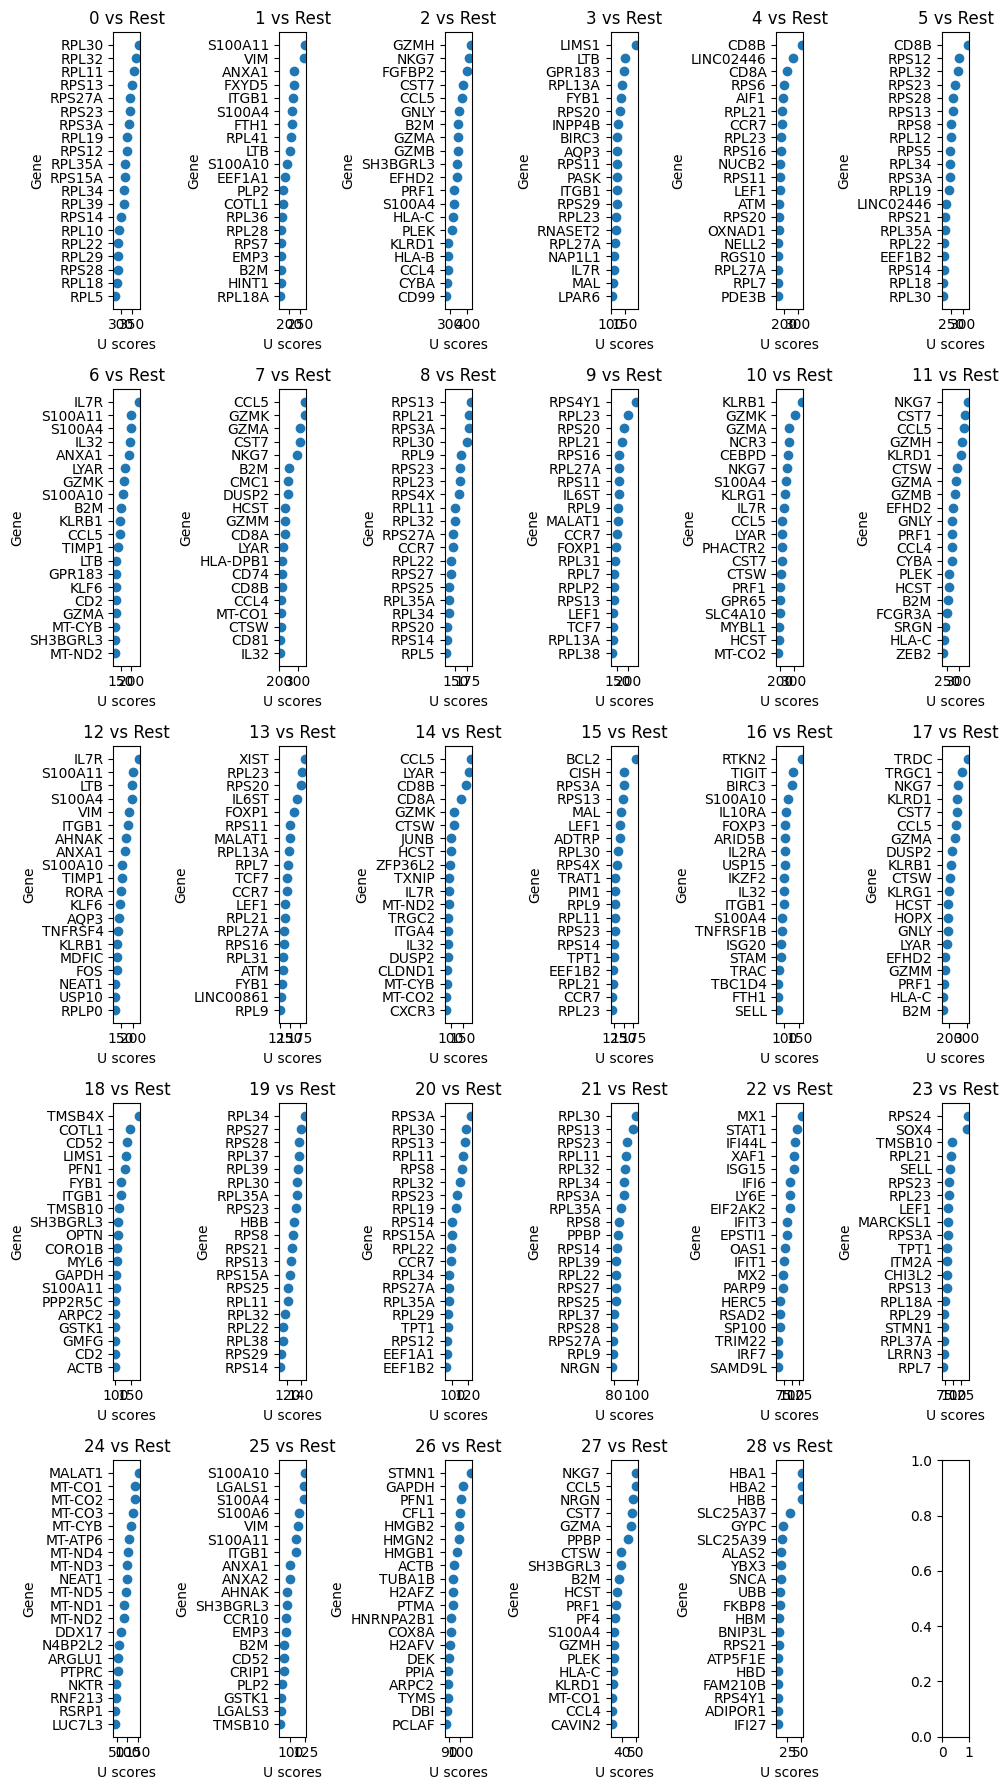

In [43]:
import matplotlib.pyplot as plt

groups = df.groupby('group')

fig, axs = plt.subplots(5, 6, figsize=(10, 18), squeeze=False)

# Loop through each group and create a scatter plot in the corresponding subplot
for i, (name, group) in enumerate(groups):
    row, col = i // 6, i % 6
    axs[row, col].scatter(group['scores'], group['names'])
    axs[row, col].invert_yaxis()
    axs[row, col].set_title(str(name)+" vs Rest")
    axs[row, col].set_xlabel('U scores')
    axs[row, col].set_ylabel('Gene')
fig.tight_layout()


In [9]:
data="eyJzIjogeyJBQVBMIjogMC4yNTEzMzQyMjgyNzc5NTgzNywgIkdPT0ciOiAwLjMzMzQ0ODg2MjYwMDY5NjcsICJBTVpOIjogMC4zNzQwODEwOTg4Nzk4MTUyLCAiTlZEQSI6IDAuNTM4MDU1NTA1MTU3MTA2MiwgIlRTTEEiOiAwLjU5Nzg3OTcxNzcxNTMwNjEsICJMTFkiOiAwLjI3NjY4OTgzNjIwNDE4ODI0LCAiSlBNIjogMC4yMTc2OTk1ODA0ODg2OTkyMiwgIlhPTSI6IDAuMjYyMjk2MTMzMzUxNzYzMiwgIkFWR08iOiAwLjMyNzYyMDM5NTAwODc0MTQ2LCAiViI6IDAuMTg4NDk2MDM0NDY5ODMzNjIsICJKTkoiOiAwLjE2NDcwMTExMTkyMTc2NDY4LCAiUEciOiAwLjE1MDIwMjgzNDg2MTMzMTQzLCAiTUEiOiAwLjIwODU5MTc5MTUxNjIyODcsICJIRCI6IDAuMjM1MTYzMzg1NTE5OTkwNzgsICJBREJFIjogMC4zNDkxNjc1NzA2MzgxMDAzLCAiTVJLIjogMC4xOTMyODA0OTI1MzQyNTk5NywgIkNPU1QiOiAwLjIwMzk5MjQyMjMzODM4OTc3LCAiQ1ZYIjogMC4yNDQyNTIzMTQxMDMyMzU3LCAiQUJCViI6IDAuMTk4Mzg2MTI4Nzc5NTcyNSwgIldNVCI6IDAuMTU1Mjg2MDI4ODQ2OTMxNzcsICJQRVAiOiAwLjE1MTE0NzI4MzUxMDg2NjQsICJLTyI6IDAuMTQxOTI1MjE3OTc0MDMzMTgsICJDU0NPIjogMC4xOTc5ODI0NDkzNTI1NTk0MywgIkNSTSI6IDAuMzQzNjEzNzk5MTgwNzUyOTcsICJBQ04iOiAwLjI2MzIyOTE3NzcxMzgxMzE2LCAiTkZMWCI6IDAuNDIyNTg1NDIwODM0MzQxMzYsICJNQ0QiOiAwLjEzOTczNTQwNzAwNTU0NTcsICJMSU4iOiAwLjIwMjgzMzk4NDQxMTQxMjU3LCAiQU1EIjogMC40OTM5NTA1MDA2NzUxNjQ2LCAiQkFDIjogMC4yNjIzODI1OTU5Mzc4NjMwNiwgIk9SQ0wiOiAwLjI3NzIwNTIwODc1MDU1NDY1LCAiQ01DU0EiOiAwLjI1Mjc4NTQ4MjI2MDkyNTg0LCAiUEZFIjogMC4yMTc2ODkwODU4ODU3MjUzMywgIkFCVCI6IDAuMjExOTMyMzI3MDAzNzgxNTYsICJJTlRDIjogMC4zODg4MDQzMDQyOTQwOTQ0NiwgIkRJUyI6IDAuMzE3MjM5OTEwMDg4NzYxNCwgIlZaIjogMC4yNDE0MTAwMDc1NjYwMjIwMiwgIldGQyI6IDAuMjc4NzY0NjE0MjI2NDY3ODcsICJJTlRVIjogMC4zNDQ3NzIxMzkyNTk5OTcyLCAiQU1HTiI6IDAuMjExMTM1OTk4NjY1MzI5NDIsICJQTSI6IDAuMTc2NTEzMzAwNTU1MDk4NDIsICJRQ09NIjogMC4zNTk3ODQ3OTE0MTc0MTcxNSwgIkNPUCI6IDAuMzE0OTU4MTAyNjg5MDI4NCwgIklCTSI6IDAuMTc2OTc4Nzg1MTM2NTc4MDUsICJTUFkiOiAwLjE1NzAwNjg0MTM3NTMzMzIyLCAiUVFRIjogMC4yMTMxMzgxNTM1OTM0NzY3NH0sICJjIjogeyJBQVBMMjMxMjI5QzAwMTg1MDAwIjogeyJTIjogMTg4LjAxLCAiSyI6IDE4NS4wfSwgIkdPT0cyMzEyMjlDMDAxMzYwMDAiOiB7IlMiOiAxMzYuMzgsICJLIjogMTM2LjB9LCAiQU1aTjIzMTIyOUMwMDE0MzAwMCI6IHsiUyI6IDE0My4yLCAiSyI6IDE0My4wfSwgIk5WREEyMzEyMjlDMDA0ODUwMDAiOiB7IlMiOiA0ODguODgsICJLIjogNDg1LjB9LCAiVFNMQTIzMTIyOUMwMDI0MDAwMCI6IHsiUyI6IDI0Mi44NCwgIksiOiAyNDAuMH0sICJMTFkyMzEyMjlDMDA1ODUwMDAiOiB7IlMiOiA1ODguNTQsICJLIjogNTg1LjB9LCAiSlBNMjMxMjI5QzAwMTQ5MDAwIjogeyJTIjogMTQ5Ljc0LCAiSyI6IDE0OS4wfSwgIlhPTTIzMTIyOVAwMDEwNDAwMCI6IHsiUyI6IDEwMy42NiwgIksiOiAxMDQuMH0sICJBVkdPMjMxMjI5QzAwOTc1MDAwIjogeyJTIjogOTc1LjQsICJLIjogOTc1LjB9LCAiVjIzMTIyOUMwMDI0NTAwMCI6IHsiUyI6IDI0OC4xMSwgIksiOiAyNDUuMH0sICJKTkoyMzEyMjlDMDAxNDUwMDAiOiB7IlMiOiAxNDguOCwgIksiOiAxNDUuMH0sICJQRzIzMTIyOVAwMDE0NTAwMCI6IHsiUyI6IDE1MS40MiwgIksiOiAxNDUuMH0sICJNQTIzMTIyOVAwMDM5NTAwMCI6IHsiUyI6IDM5Ni44MywgIksiOiAzOTUuMH0sICJIRDIzMTIyOUMwMDMwNTAwMCI6IHsiUyI6IDMwOC4xOSwgIksiOiAzMDUuMH0sICJBREJFMjMxMjI5UDAwNTkwMDAwIjogeyJTIjogNTk1LjMxLCAiSyI6IDU5MC4wfSwgIk1SSzIzMTIyOVAwMDEwMjAwMCI6IHsiUyI6IDEwMS4zNSwgIksiOiAxMDIuMH0sICJDT1NUMjMxMjI5QzAwNTk1MDAwIjogeyJTIjogNTk2Ljc4LCAiSyI6IDU5NS4wfSwgIkNWWDIzMTIyOUMwMDE0NTAwMCI6IHsiUyI6IDE0NS41NiwgIksiOiAxNDUuMH0sICJBQkJWMjMxMjI5UDAwMTM4MDAwIjogeyJTIjogMTM3LjYsICJLIjogMTM4LjB9LCAiV01UMjMxMjI5QzAwMTY1MDAwIjogeyJTIjogMTY5Ljc4LCAiSyI6IDE2NS4wfSwgIlBFUDIzMTIyOUMwMDE2NTAwMCI6IHsiUyI6IDE2Ny4yNSwgIksiOiAxNjUuMH0sICJLTzIzMTIyOUMwMDA1NzAwMCI6IHsiUyI6IDU3LjIxLCAiSyI6IDU3LjB9LCAiQ1NDTzIzMTIyOUMwMDA1MzAwMCI6IHsiUyI6IDUzLjI4LCAiSyI6IDUzLjB9LCAiQ1JNMjMxMjI5UDAwMjIwMDAwIjogeyJTIjogMjE5LjQyLCAiSyI6IDIyMC4wfSwgIkFDTjIzMTIyOUMwMDMzNTAwMCI6IHsiUyI6IDMyNS41LCAiSyI6IDMzNS4wfSwgIk5GTFgyMzEyMjlDMDA0NjAwMDAiOiB7IlMiOiA0NjEuOTQsICJLIjogNDYwLjB9LCAiTUNEMjMxMjI5UDAwMjY1MDAwIjogeyJTIjogMjcwLjM5LCAiSyI6IDI2NS4wfSwgIkFNRDIzMTIyOVAwMDExOTAwMCI6IHsiUyI6IDExOC4wLCAiSyI6IDExOS4wfSwgIkJBQzIzMTIyOUMwMDAzMDAwMCI6IHsiUyI6IDI5LjYyLCAiSyI6IDMwLjB9LCAiT1JDTDIzMTIyOVAwMDExMTAwMCI6IHsiUyI6IDExNC4wNiwgIksiOiAxMTEuMH0sICJDTUNTQTIzMTIyOUMwMDA0MjAwMCI6IHsiUyI6IDQyLjUzLCAiSyI6IDQyLjB9LCAiUEZFMjMxMjI5QzAwMDMwMDAwIjogeyJTIjogMzAuMTksICJLIjogMzAuMH0sICJBQlQyMzEyMjlDMDAwOTgwMDAiOiB7IlMiOiA5OC4wLCAiSyI6IDk4LjB9LCAiSU5UQzIzMTIyOUMwMDA0MDAwMCI6IHsiUyI6IDQwLjYxLCAiSyI6IDQwLjB9LCAiRElTMjMxMjI5QzAwMDkzMDAwIjogeyJTIjogOTMuOTMsICJLIjogOTMuMH0sICJWWjIzMTIyOUMwMDAzNTAwMCI6IHsiUyI6IDM2LjAsICJLIjogMzUuMH0sICJXRkMyMzEyMjlDMDAwNDIwMDAiOiB7IlMiOiA0Mi44NCwgIksiOiA0Mi4wfSwgIkFNR04yMzEyMjlDMDAyNzAwMDAiOiB7IlMiOiAyNzMuMDMsICJLIjogMjcwLjB9LCAiUUNPTTIzMTIyOUMwMDEyODAwMCI6IHsiUyI6IDEyOC45MiwgIksiOiAxMjguMH0sICJDT1AyMzEyMjlQMDAxMTYwMDAiOiB7IlMiOiAxMTUuMDMsICJLIjogMTE2LjB9LCAiSUJNMjMxMjI5QzAwMTUyNTAwIjogeyJTIjogMTUyLjU4LCAiSyI6IDE1Mi41fSwgIlNQWTIzMTIyOUMwMDQ0OTAwMCI6IHsiUyI6IDQ0OS42OCwgIksiOiA0NDkuMH0sICJRUVEyMzEyMjlDMDAzNDkwMDAiOiB7IlMiOiAzODUuNjIsICJLIjogMzQ5LjB9fX0="

In [10]:
sum([round(premium(c, data.s, r=0.05, T=0.13778), 2) for c in data.c])

AttributeError: 'str' object has no attribute 'c'